In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
# Generate Data

In [3]:
true_b = 1
true_w = 2
N = 100

In [4]:
np.random.seed(42)
X = np.random.rand(N, 1)
epsilon = (0.1 * np.random.randn(N, 1))
y = true_w * X + true_b + epsilon

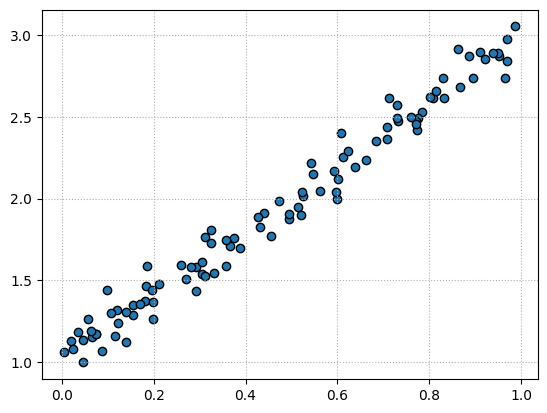

In [5]:
fig, ax = plt.subplots()
ax.scatter(X, y, edgecolor='k')
ax.grid(True, linestyle=':')
plt.show()

In [6]:
# Train Validation Split

In [7]:
idx = np.arange(N)
np.random.shuffle(idx)

train_idx = idx[:int(N * 0.8)]
val_idx = idx[int(N * 0.8):]

In [8]:
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

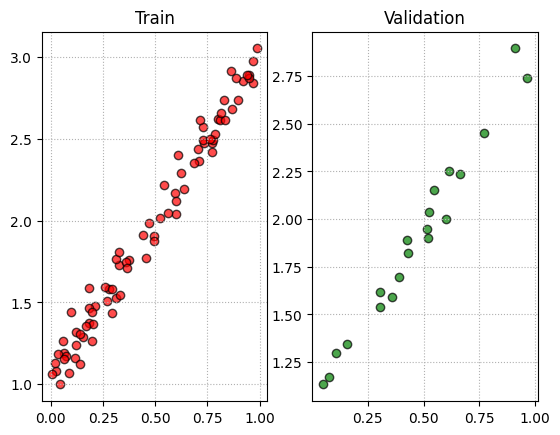

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(X_train, y_train, edgecolor='k', c='r', alpha=.7)
ax1.grid(True, linestyle=':')
ax1.set_title('Train')

ax2.scatter(X_val, y_val, edgecolor='k', c='g', alpha=.7)
ax2.grid(True, linestyle=':')
ax2.set_title('Validation')
plt.show()

In [10]:
# Inicializando w e b aleatorios

In [11]:
np.random.seed(42)
w = np.random.randn(1)
b = np.random.randn(1)

print(w, b)

[0.49671415] [-0.1382643]


In [12]:
y_hat =  b + w * X_train

In [13]:
idx_sort = np.argsort(X_train[:, 0])

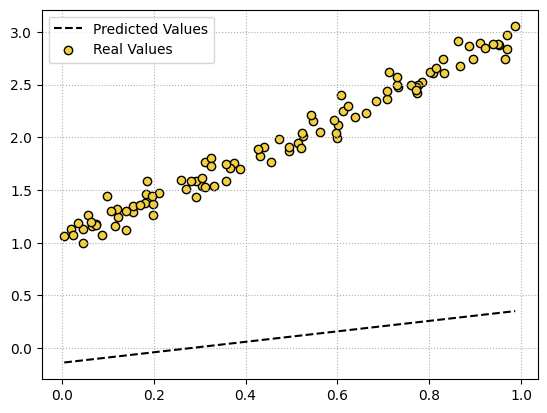

In [14]:
fig, ax = plt.subplots()
ax.plot(
    X_train[idx_sort],
    y_hat[idx_sort], 
    linestyle='--', 
    c='k',
    label='Predicted Values'
)
ax.scatter(
    X, 
    y, 
    c='#f4d03f', 
    edgecolor='k', 
    label='Real Values'
)
ax.grid(True, linestyle=':')
plt.legend()
plt.show()

# Correct way to create tensors with requires_grad

In [15]:
import torch

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

In [18]:
b

tensor([-0.4520], device='cuda:0', requires_grad=True)

# Autograd
*Autograd* is Pytorch's automatic differentiation package. We **don't need to worry** about *partial derivatives, chain rule, or anything* like it.
**backward()** method compute gradients for all (gradient-requiring) tensor involved in the computation of a given variable.

In [19]:
X_train_tensor = torch.as_tensor(X_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

In [20]:
y_hat = w * X_train_tensor + b

In [21]:
error = (y_hat - y_train_tensor)
loss = (error ** 2).mean()

In [22]:
loss

tensor(7.9563, device='cuda:0', grad_fn=<MeanBackward0>)

In [23]:
loss.backward()

In [24]:
print('Grad b:', b.grad)
print('Grad w:', w.grad)

Grad b: tensor([-5.4088], device='cuda:0')
Grad w: tensor([-3.0433], device='cuda:0')


In [25]:
# O Gradiente acumula e agora o grad é exatamente o dobro:
# 2x
y_hat = w * X_train_tensor + b
error = (y_hat - y_train_tensor)
loss = (error ** 2).mean()
loss.backward()

print('Grad b:', b.grad)
print('Grad w:', w.grad)

Grad b: tensor([-10.8176], device='cuda:0')
Grad w: tensor([-6.0865], device='cuda:0')


<span style="color:red"><strong>IMPORTANTE:</strong></span> Se um tensor é usado para calcular outro ele será incluido na lista de diferenciação, capturar essas dependencias é exatamente o que a **dynamic computation graph** faz.

In [26]:
print(f'{error.requires_grad=}')
print(f'{y_hat.requires_grad=}')
print(f'{b.requires_grad=}')
print(f'{w.requires_grad=}')

error.requires_grad=True
y_hat.requires_grad=True
b.requires_grad=True
w.requires_grad=True


In [27]:
print(f'{y_train_tensor.requires_grad=}')  # backward não se importa com ele
print(f'{X_train_tensor.requires_grad=}')  # backward não se importa com ele

y_train_tensor.requires_grad=False
X_train_tensor.requires_grad=False


<span style="color:red"><strong>IMPORTANTE:</strong></span> O **Pytorch** acumula gradientes, e isso pode ser usado aqui. Quando sua maquina não é tão boa ele pode pegar o seu *mini-batch* e fazer dele *sub mini-batchs* pois ele não pode (consegue) jogar tudo de uma vez na memoria, por isso ele vai acumulando o gradiente para depois utilizar. Ele parcela o *mini-batch* basicamente.

We need to **zero the gradients afterward**. And that's what *zero_()* is good for. This resets the gradient.

In [29]:
b.grad.zero_(), w.grad.zero_()

(tensor([0.], device='cuda:0'), tensor([0.], device='cuda:0'))

In [30]:
# update
lr = 0.1
SEED = 42
EPOCHS = 1000

torch.manual_seed(SEED)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(EPOCHS):
    # forward pass
    y_hat = b + w * X_train_tensor

    # calculate the loss
    error = (y_hat - y_train_tensor)
    loss = (error ** 2).mean()

    # computes gradients for both 'b' and 'w'
    loss.backward()

    # updating the parameters
    # torch.no_grad() nos permite realizaar operações regulares sem afetar o gráfico de computação do Pytorch
    # Não se atualiza sem torch.no_grad()
    with torch.no_grad():
        b -= lr * b.grad
        w -= lr * w.grad

    b.grad.zero_()
    w.grad.zero_()

In [31]:
print(b)
print(w)

tensor([1.0235], device='cuda:0', requires_grad=True)
tensor([1.9690], device='cuda:0', requires_grad=True)


In [32]:
y_hat = b + w * X_train_tensor

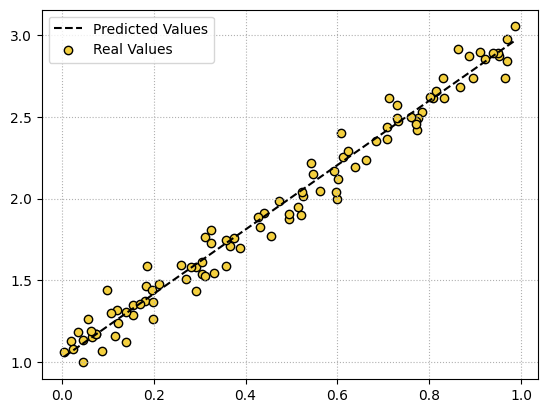

In [43]:
fig, ax = plt.subplots()
ax.plot(
    X_train_tensor[idx_sort].cpu().numpy(),
    y_hat[idx_sort].cpu().detach().numpy(),
    linestyle='--', 
    c='k',
    label='Predicted Values'
)
ax.scatter(
    X, 
    y, 
    c='#f4d03f', 
    edgecolor='k', 
    label='Real Values'
)
ax.grid(True, linestyle=':')
plt.legend()
plt.show()

Dynamic Computation Graph:


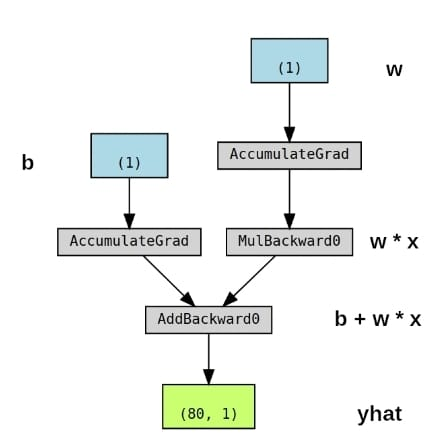

Why don't we have a box for our *data (X)*?  
R: We do not compute gradients for it!